In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [88]:
ts = pd.read_csv("../datasets/power_usage_2016_to_2020.csv",
                 index_col=0, parse_dates=True)

In [89]:
ts.shape

(35952, 3)

In [90]:
ts.head()

,Value (kWh),day_of_week,notes
StartDate,,,
2016-01-06 00:00:00,1.057,2,weekday
2016-01-06 01:00:00,1.171,2,weekday
2016-01-06 02:00:00,0.560,2,weekday
2016-01-06 03:00:00,0.828,2,weekday
2016-01-06 04:00:00,0.932,2,weekday


In [91]:
# Рассмотрим потребление энергии по дням, а не по часам
ts = ts.resample("1D").sum()
ts

C:\Users\1\AppData\Local\Temp\ipykernel_14140\984112008.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts = ts.resample("1D").sum()


,Value (kWh),day_of_week
StartDate,,
2016-01-06,29.691,48
2016-01-07,43.177,72
2016-01-08,50.057,96
2016-01-09,47.363,120
2016-01-10,42.203,144
...,...,...
2020-12-02,12.087,48
2020-12-03,16.130,72
2020-12-04,18.011,96


In [92]:
ts.drop(["day_of_week"], axis=1, inplace=True)
ts.head()

,Value (kWh)
StartDate,
2016-01-06,29.691
2016-01-07,43.177
2016-01-08,50.057
2016-01-09,47.363
2016-01-10,42.203


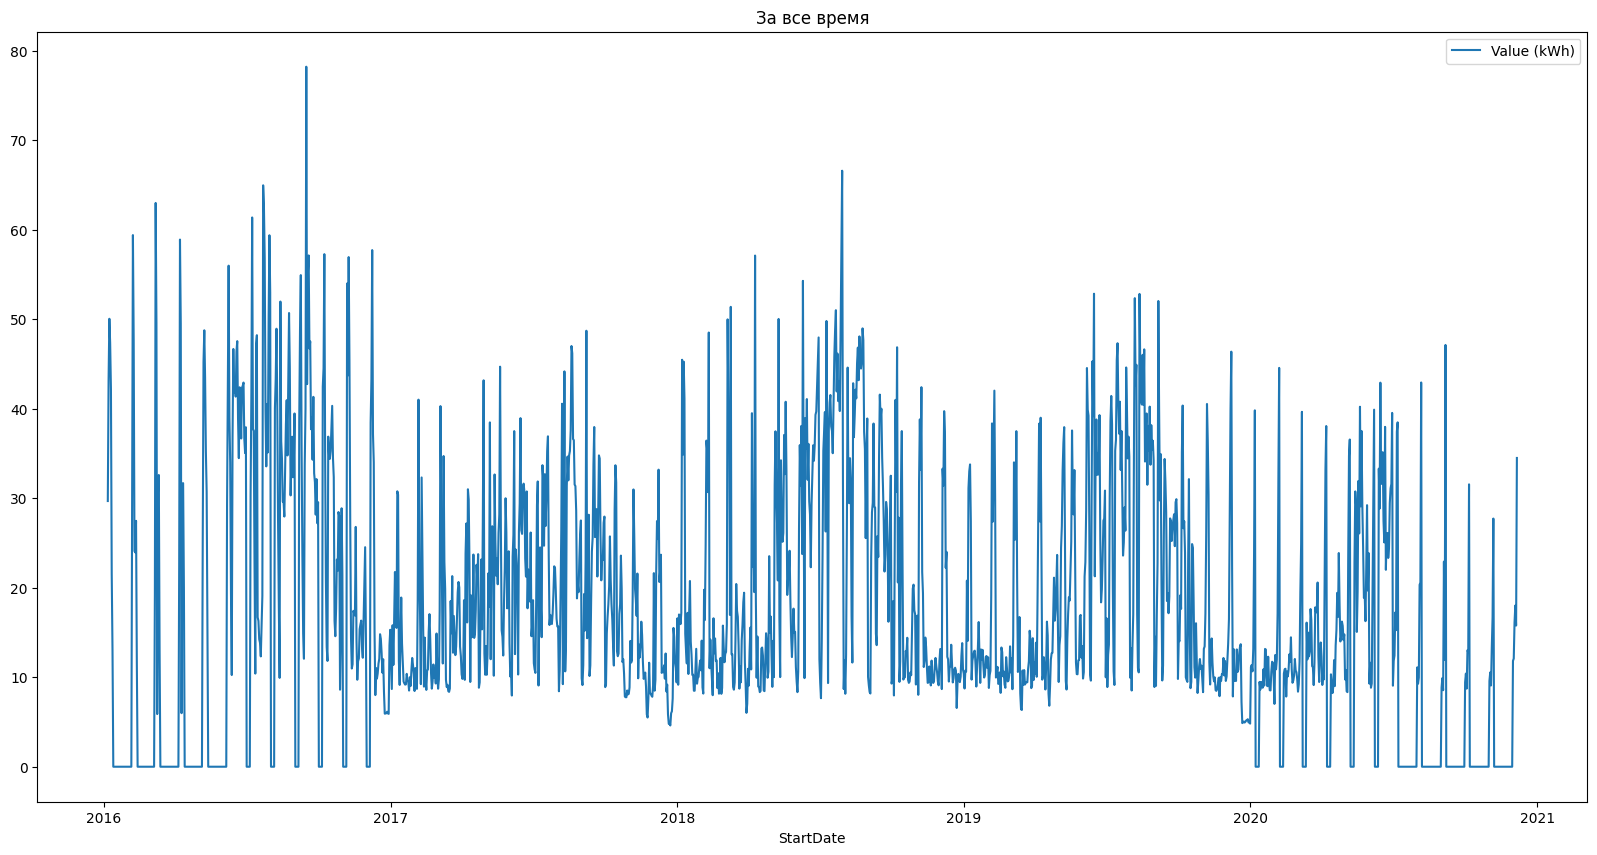

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=ts, ax=ax).set(title="За все время")
plt.show()

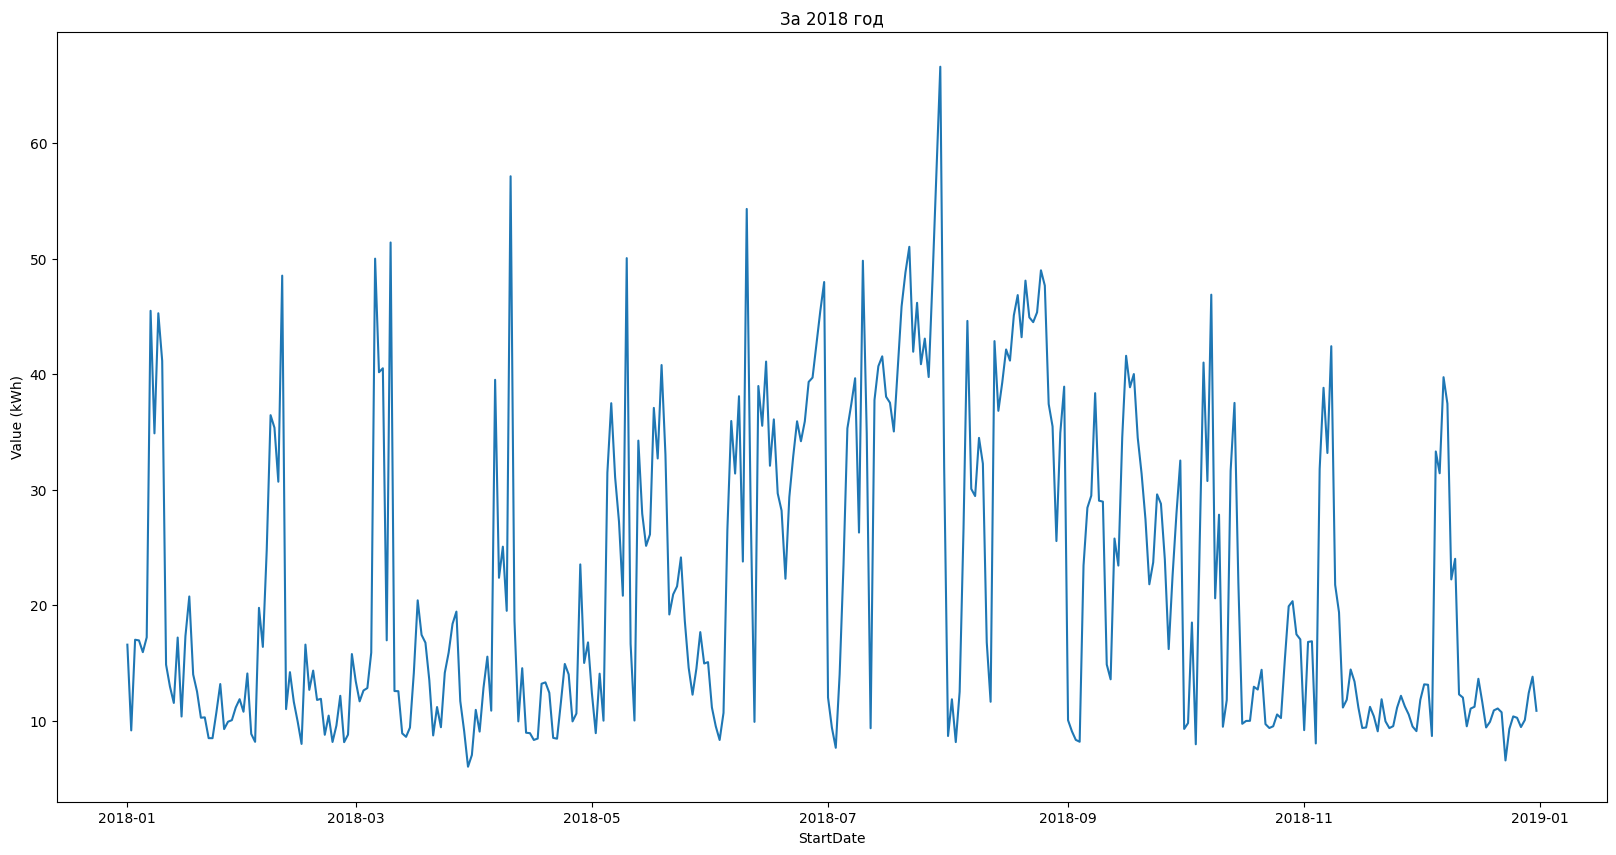

In [94]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=ts["Value (kWh)"]["2018"], ax=ax).set(title="За 2018 год")
plt.show()

C:\Users\1\AppData\Local\Temp\ipykernel_14140\2197409527.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ts, axlabel="Value (kWh)", label="Плотность распределения потребления энергии")


<AxesSubplot: xlabel='Value (kWh)', ylabel='Density'>

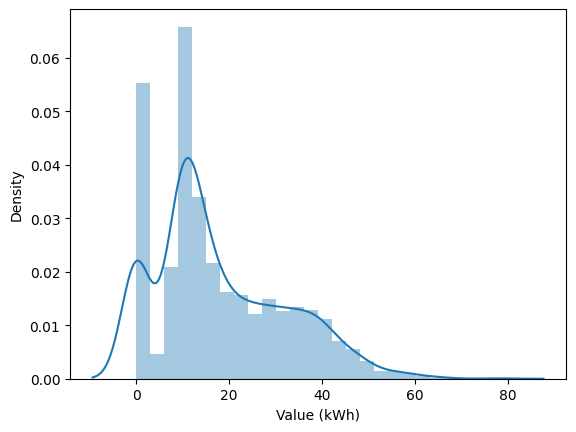

In [95]:
sns.distplot(ts, axlabel="Value (kWh)", label="Плотность распределения потребления энергии")

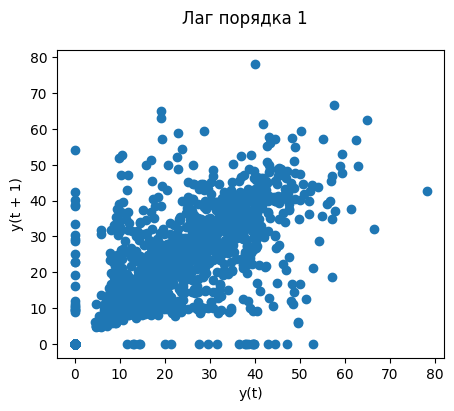

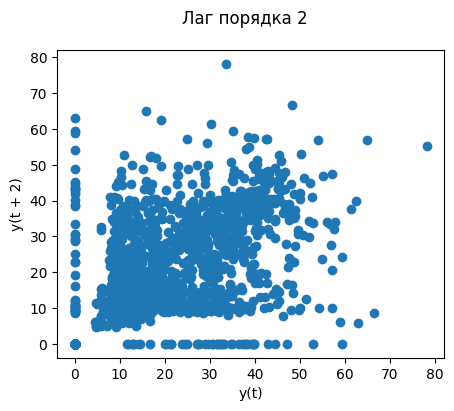

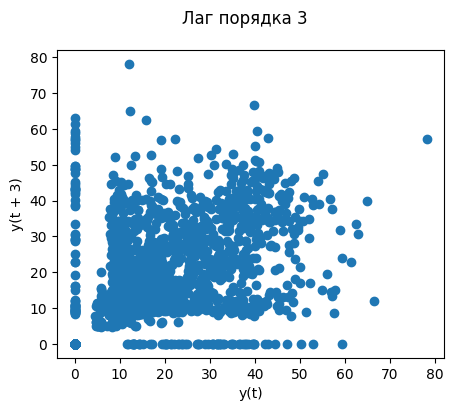

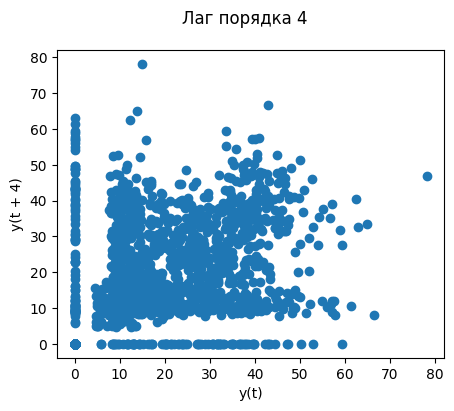

In [96]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(ts, lag=i, ax=ax)
    pyplot.show()

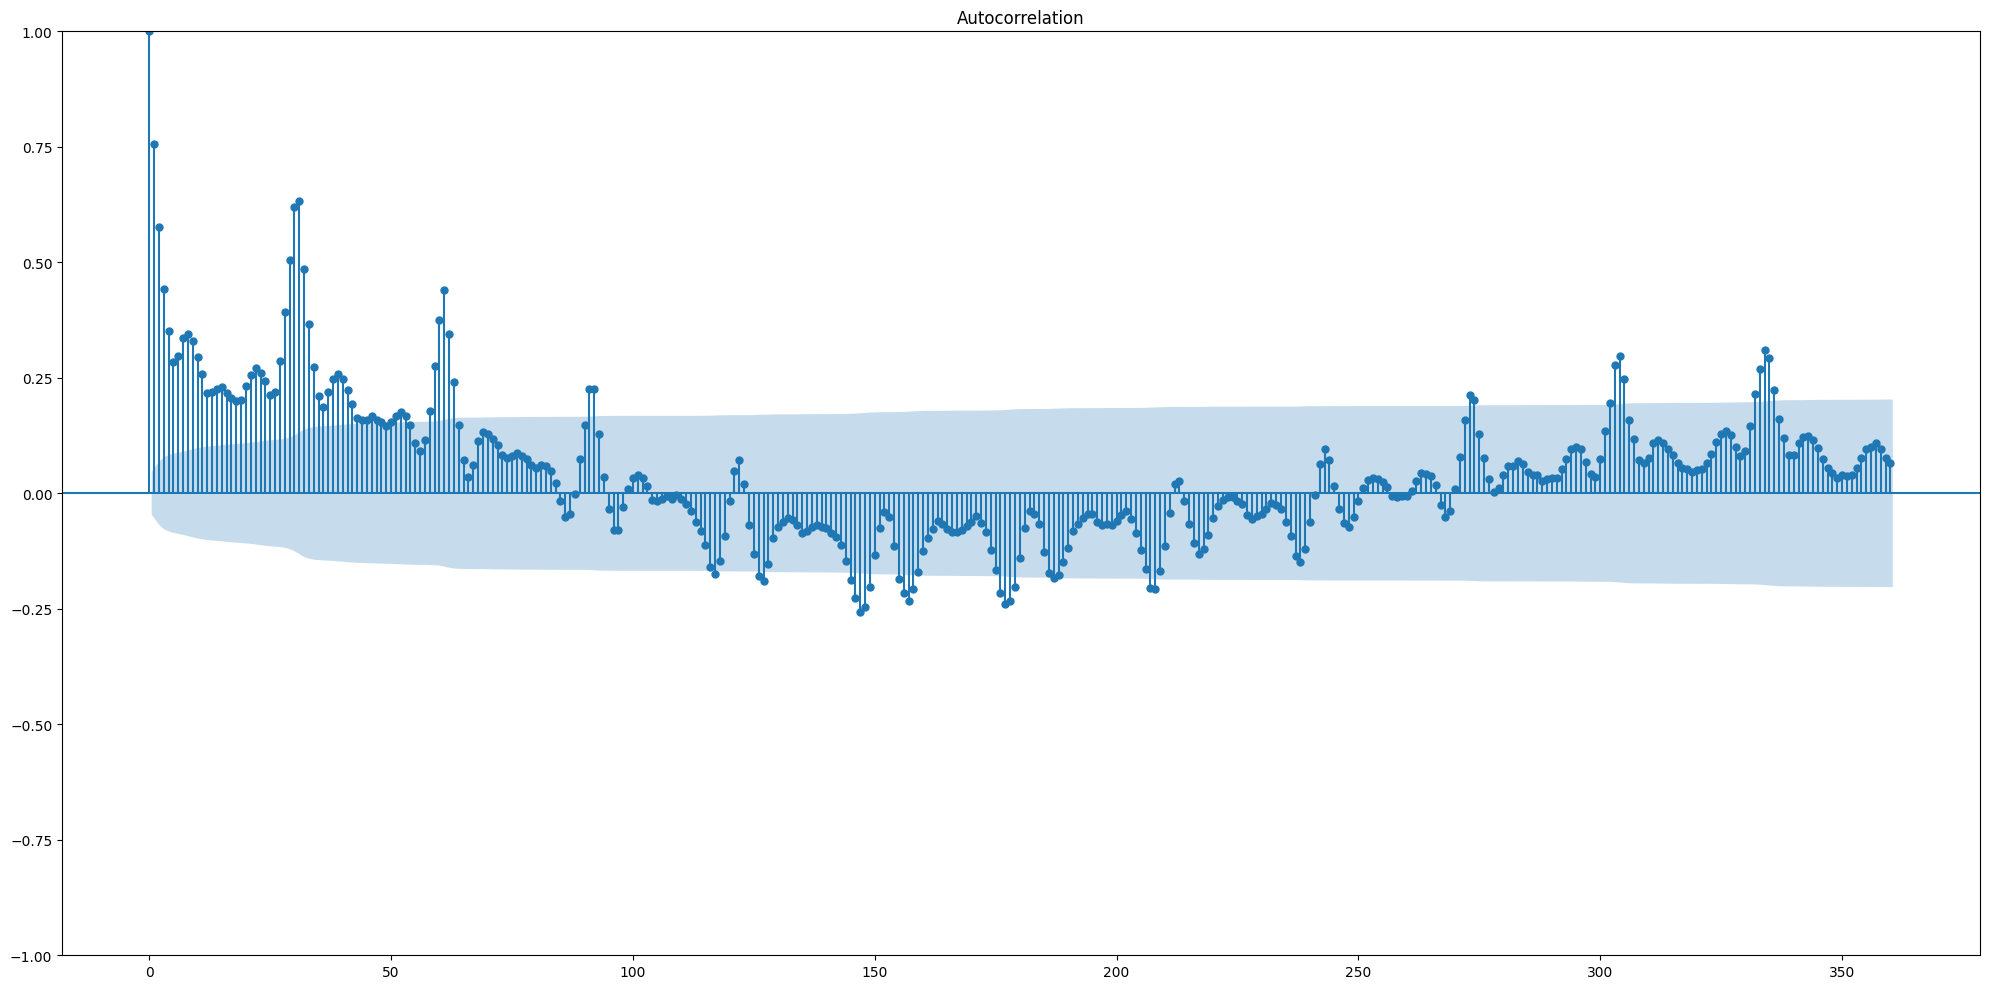

In [103]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = pyplot.subplots(figsize=(20, 10))
plot_acf(ts, lags=30*12, ax=ax)
plt.tight_layout()
pyplot.show()

In [111]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
from statsmodels.tsa.seasonal import seasonal_decompose
# Аддитивная модель
def plot_decompose(data=ts, model='add'):
    result_add = seasonal_decompose(data, model=model)
    fig = result_add.plot()
    fig.set_size_inches((10, 8))
    # Перерисовка
    fig.tight_layout()
    plt.show()

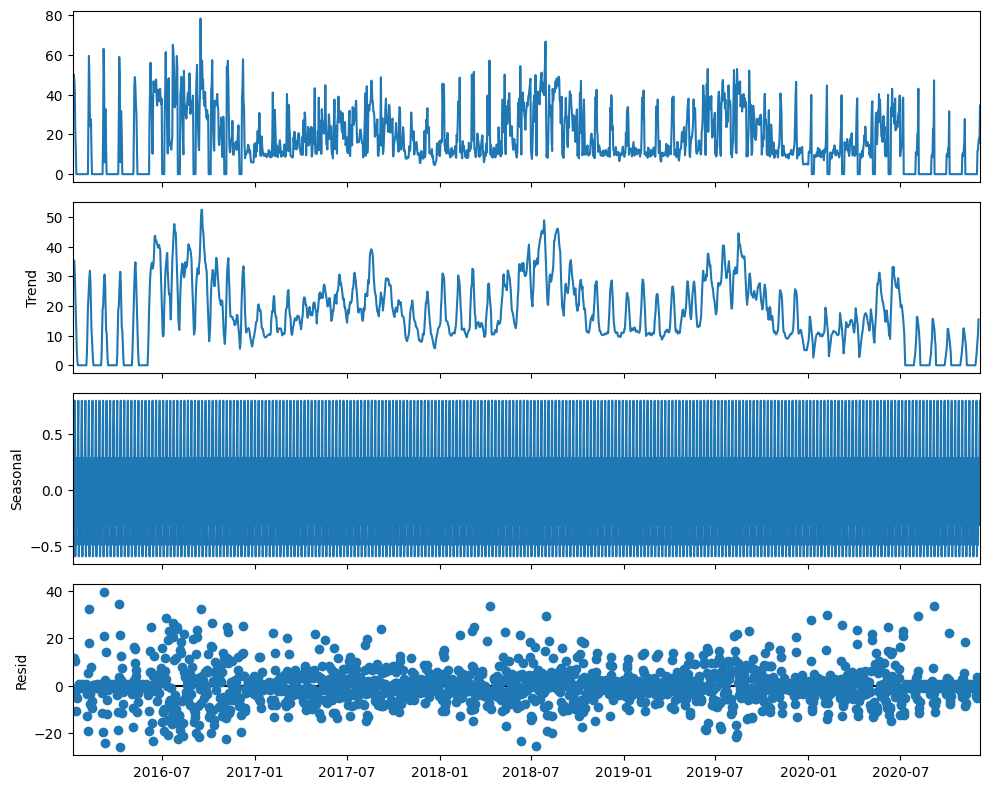

In [112]:
plot_decompose(data=ts, model='add')

In [113]:
plot_decompose(data=ts, model='mul')

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [116]:
ts2 = ts.copy()
ts2

,Value (kWh)
StartDate,
2016-01-06,29.691
2016-01-07,43.177
2016-01-08,50.057
2016-01-09,47.363
2016-01-10,42.203
...,...
2020-12-02,12.087
2020-12-03,16.130
2020-12-04,18.011


In [117]:
# Простое скользящее среднее (SMA)
ts2['SMA_W'] = ts2['Value (kWh)'].rolling(7, min_periods=1).mean()
ts2['SMA_M'] = ts2['Value (kWh)'].rolling(30, min_periods=1).mean()
ts2['SMA_Y'] = ts2['Value (kWh)'].rolling(30*12, min_periods=1).mean()

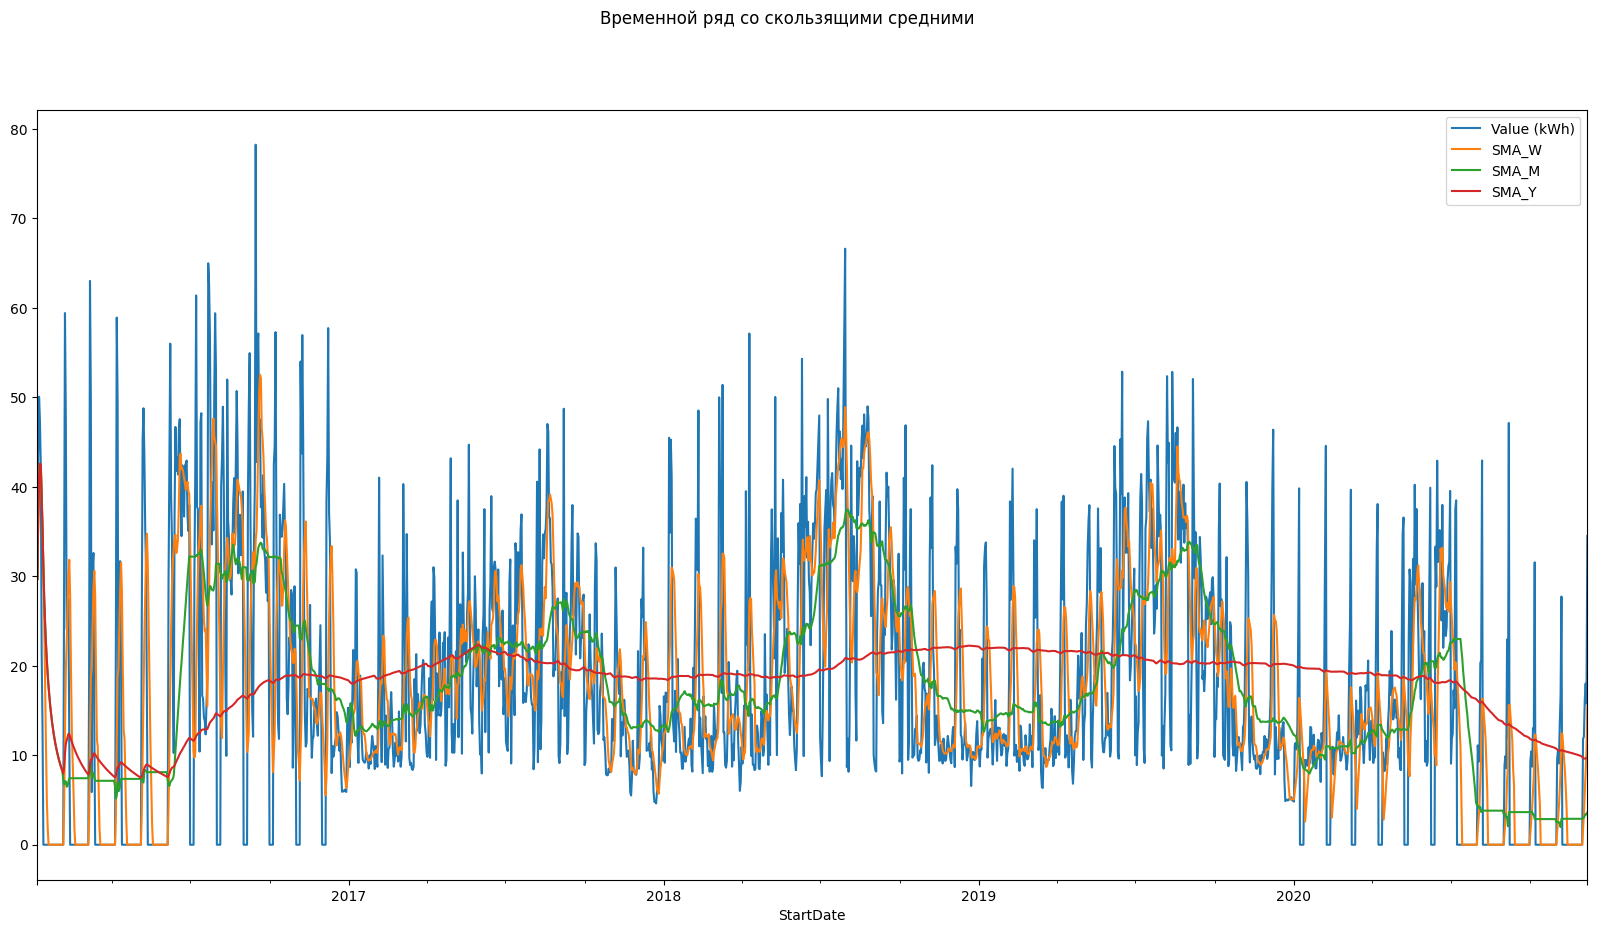

In [119]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Временной ряд со скользящими средними')
ts2.plot(ax=ax, legend=True)
pyplot.show()

In [120]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [121]:
# Целочисленная метка шкалы времени
xnum = list(range(ts2.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = ts2['Value (kWh)'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

In [122]:
# Параметры модели (p,d,q)
arima_order = (6,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [123]:
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

In [124]:
# Ошибка прогноза
np.mean(Y), error_arima, error_es

(17.838577469140233, 8.42599597975321, 8.998657563712838)

In [125]:
# Записываем предсказания в DataFrame
ts2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
ts2['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)

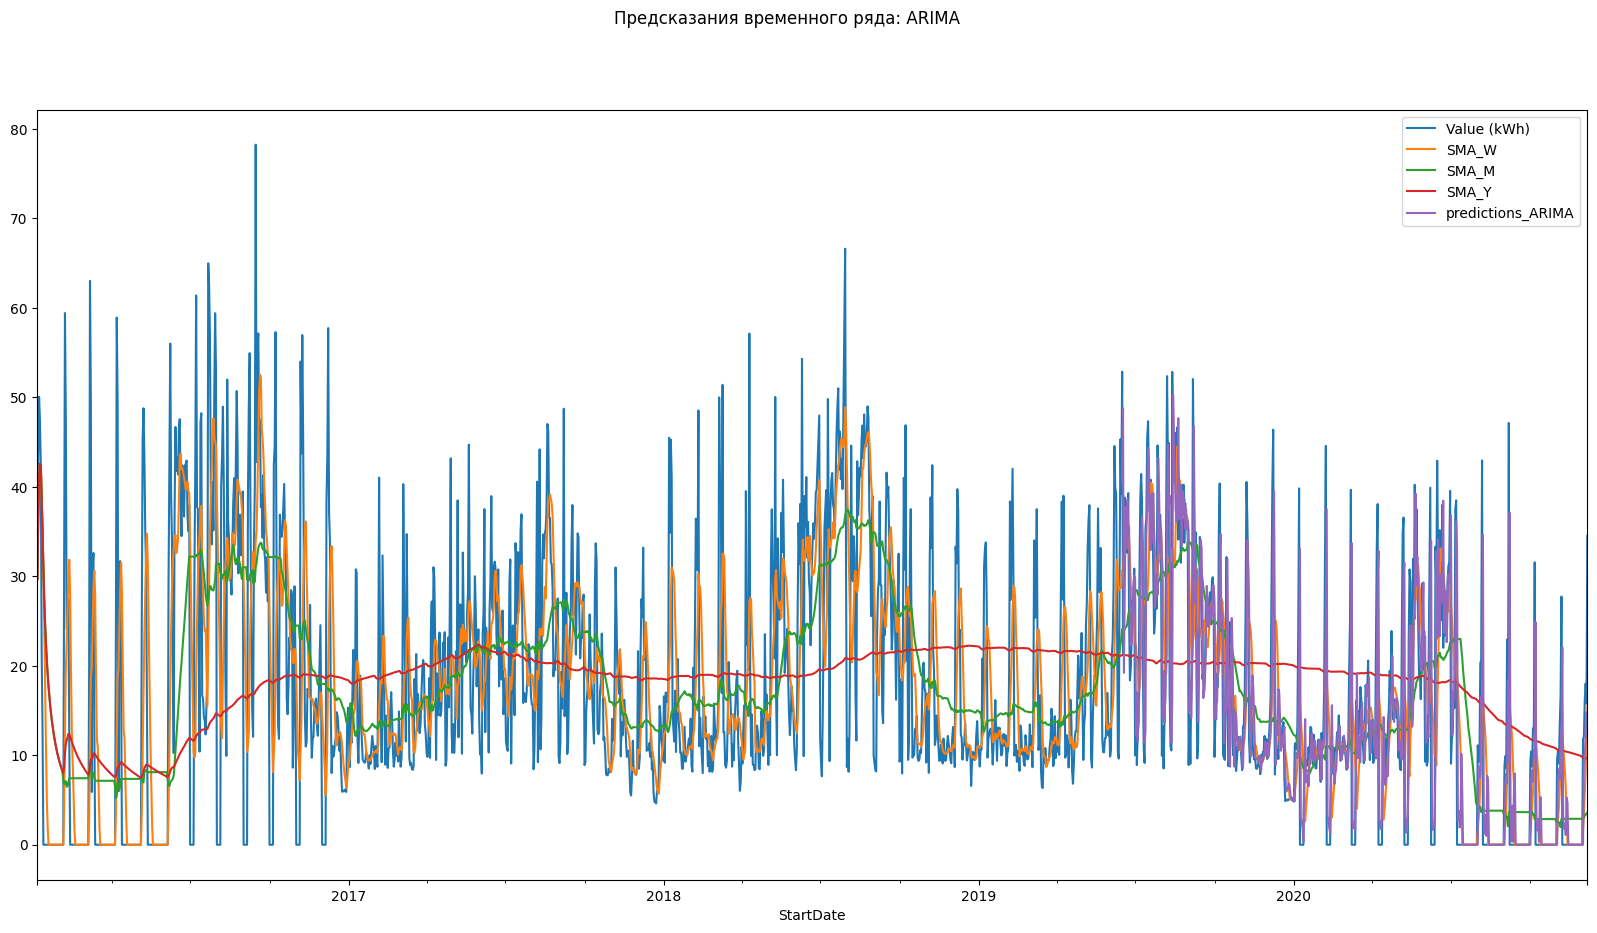

In [132]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда: ARIMA')
ts2.drop(["predictions_HWES"], axis=1).plot(ax=ax, legend=True)
pyplot.show()

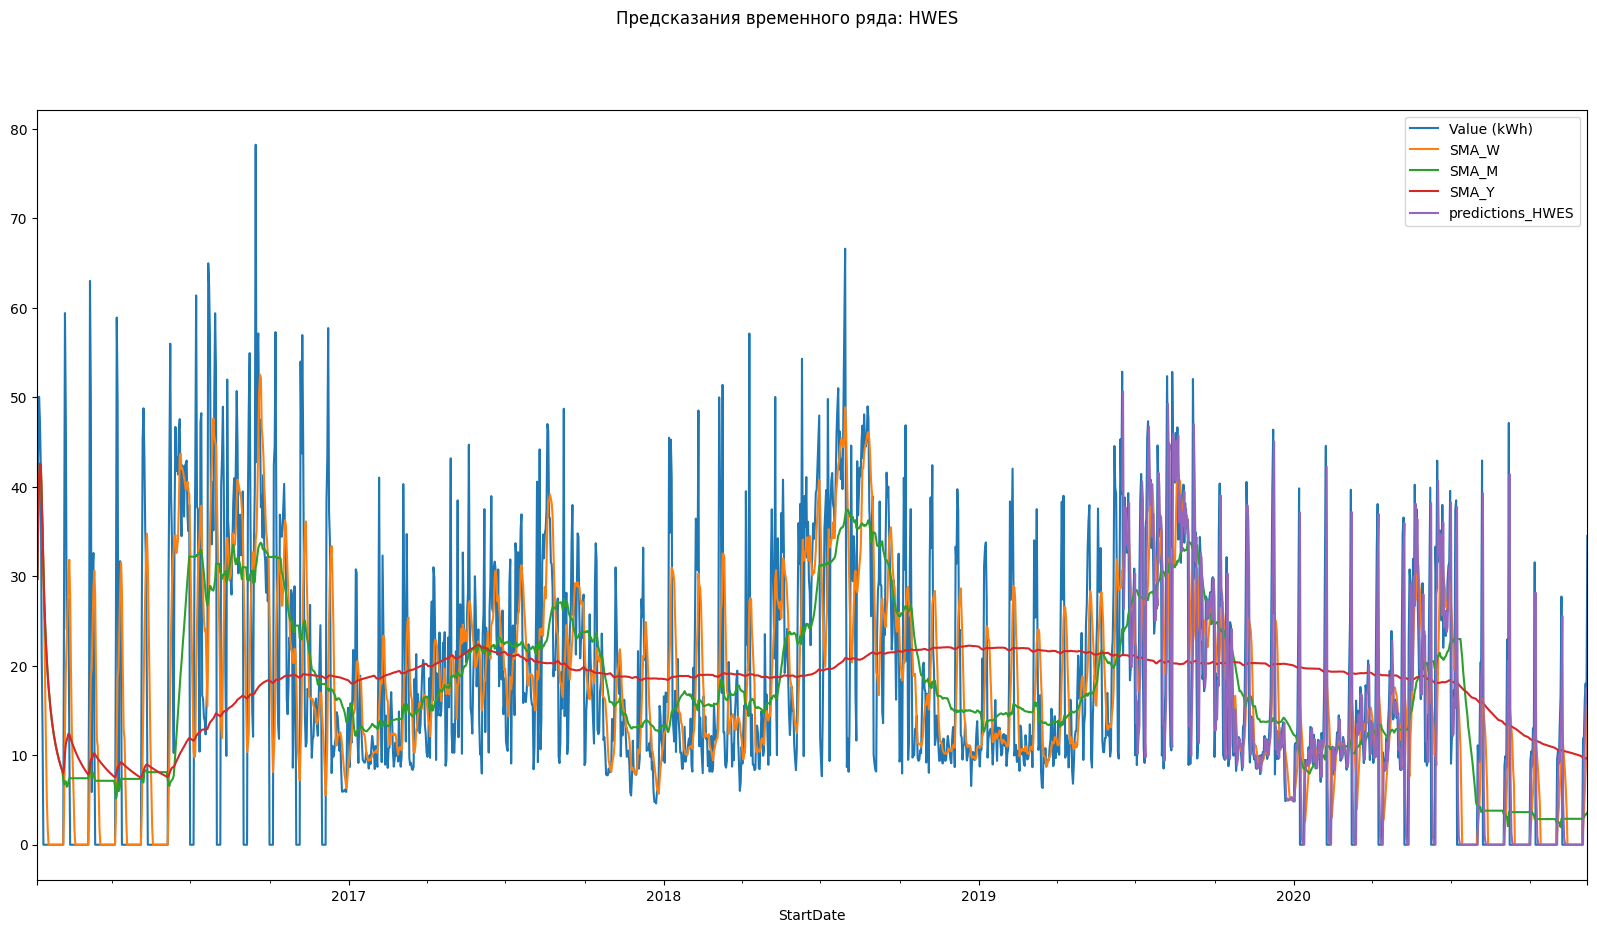

In [133]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда: HWES')
ts2.drop(["predictions_ARIMA"], axis=1).plot(ax=ax, legend=True)
pyplot.show()

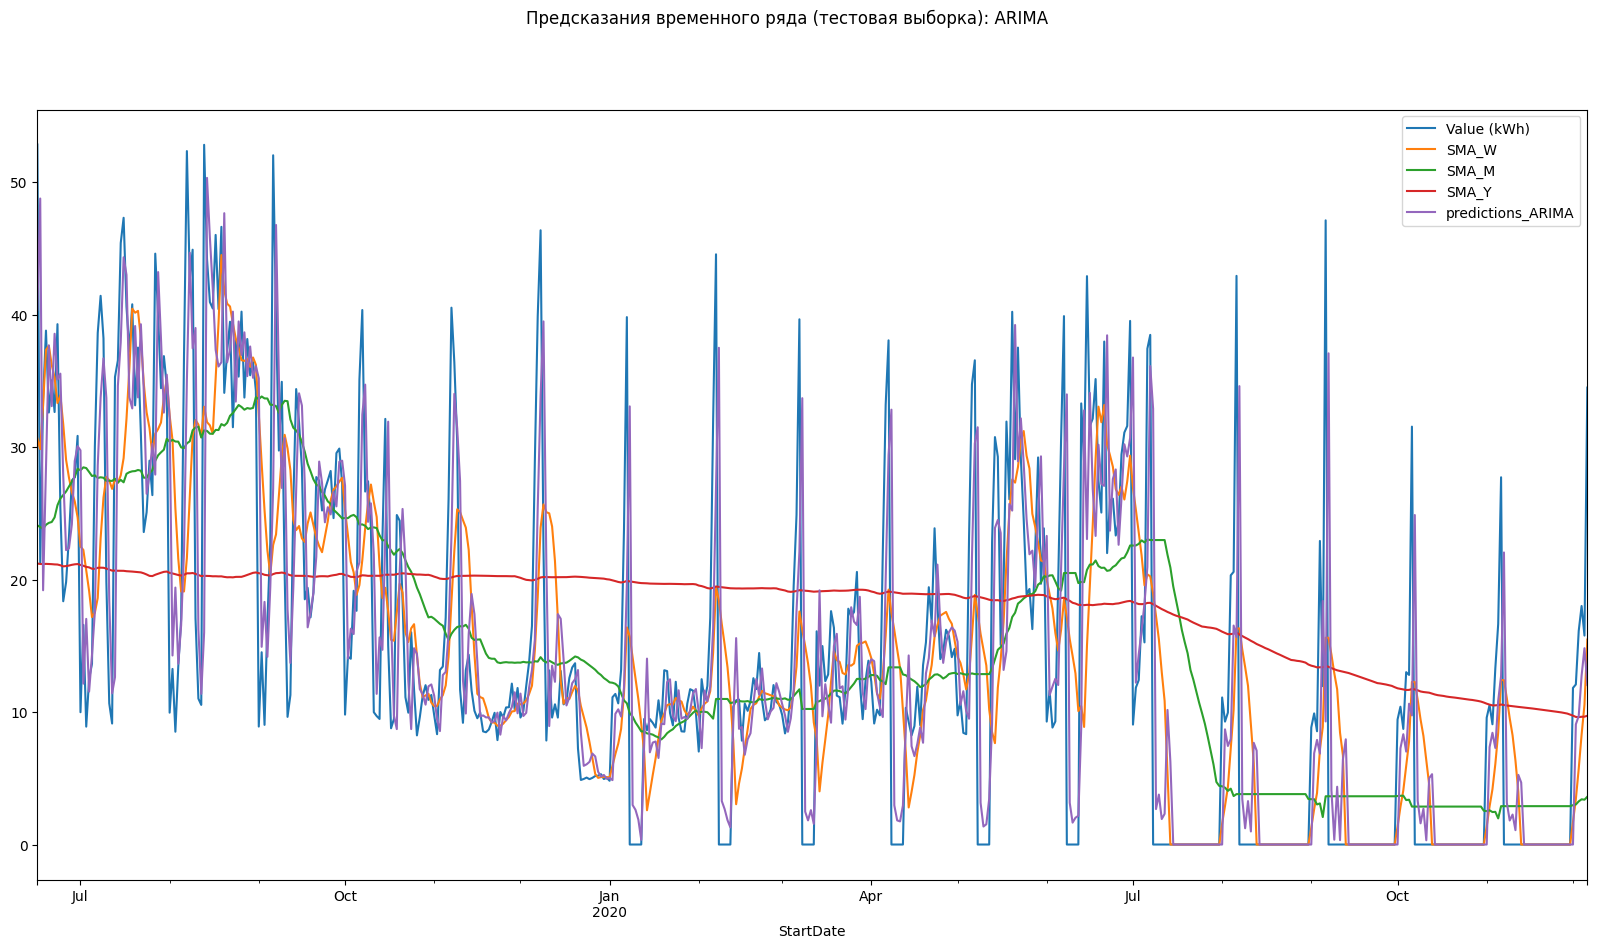

In [138]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда (тестовая выборка): ARIMA')
ts2.drop(["predictions_HWES"], axis=1)[train_size:].plot(ax=ax, legend=True)
pyplot.show()

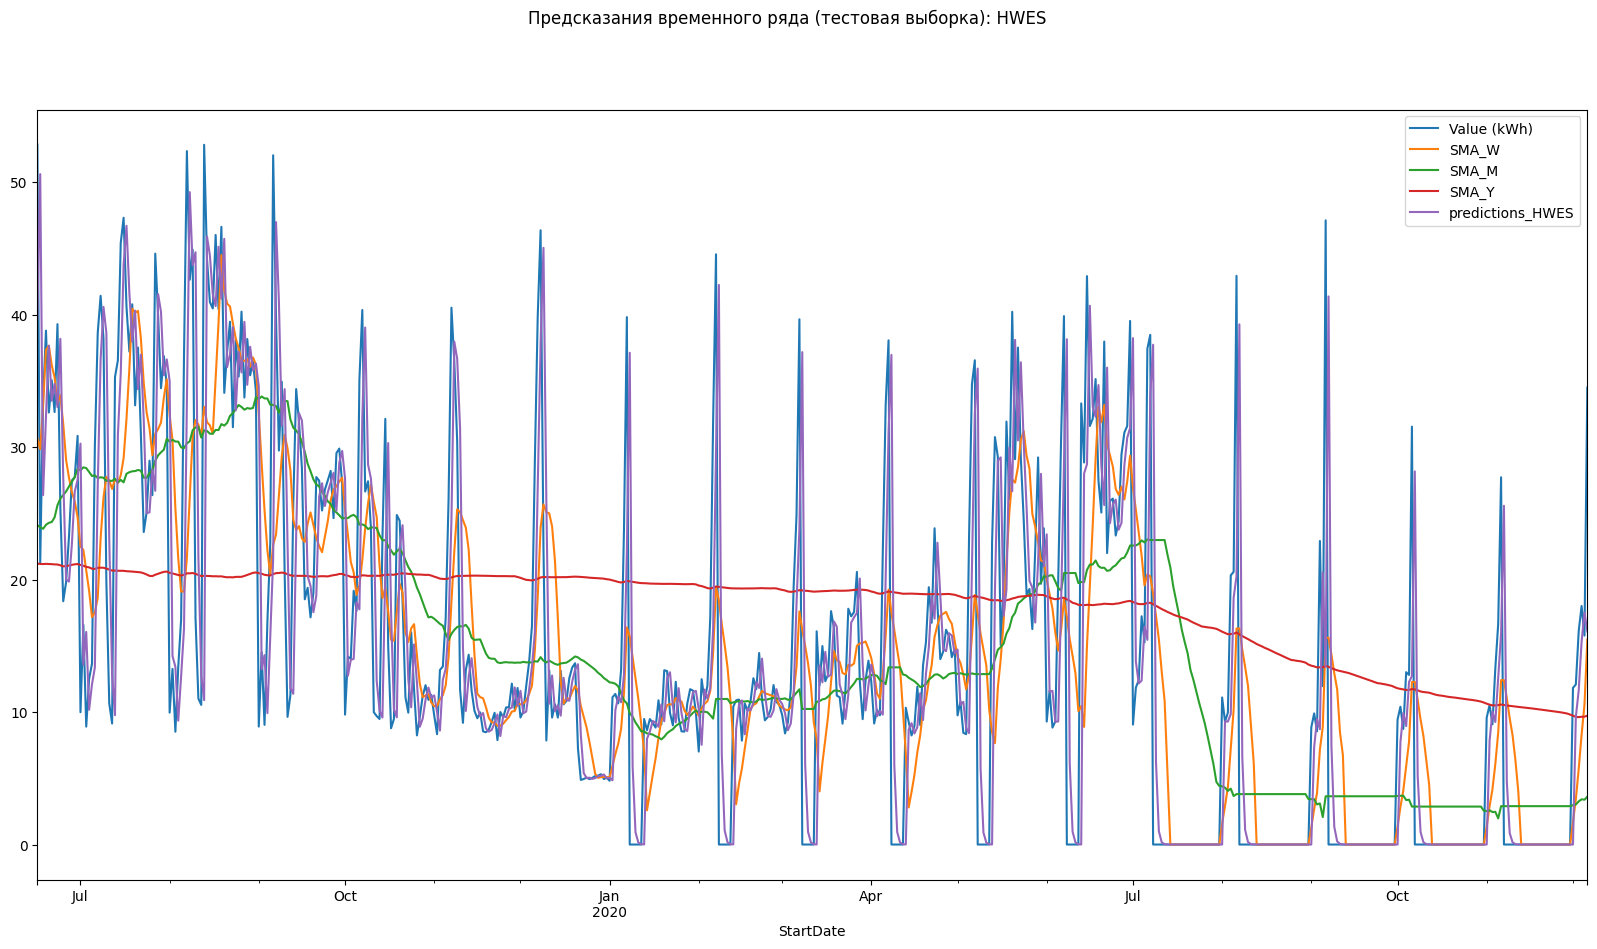

In [137]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда (тестовая выборка): HWES')
ts2.drop(["predictions_ARIMA"], axis=1)[train_size:].plot(ax=ax, legend=True)
pyplot.show()

In [139]:
from gplearn.genetic import SymbolicRegressor

In [140]:
function_set = ['add', 'sub', 'mul', 'div', 'sin', 'cos']
est_gp = SymbolicRegressor(population_size=1000, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [141]:
est_gp.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

D:\JetBrains\PyCharm 2021.2.2\PycharmProjects\oad\LR10\.venv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   142.11      1.25857e+53       50          197.319              N/A      2.21m
   1    92.47       1.5223e+15       75          196.596              N/A      1.08m
   2    71.52      1.52069e+15       60          195.807              N/A     50.30s
   3    58.84      8.70579e+10       61          195.071              N/A     46.16s
   4    54.20      1.55742e+10       52          192.877              N/A     42.56s
   5    60.77      4.93417e+09       59          192.447              N/A     47.04s
   6    61.63      1.75638e+09       58          192.407              N/A     44.72s
   7    59.82      1.24454e+12       52           190.98              N/A     43.74s
   8    57.99      5.30206e+09       62          189.536              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin', 'cos'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [150]:
import graphviz
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render(view=True)

'Source.gv.pdf'

In [143]:
# Предсказания
y_gp = est_gp.predict(np.array(xnum_test).reshape(-1, 1))

In [146]:
error_gp = mean_squared_error(test, y_gp, squared=False)
error_gp

14.714058780409108

In [144]:
# Записываем предсказания в DataFrame
ts2['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_gp)

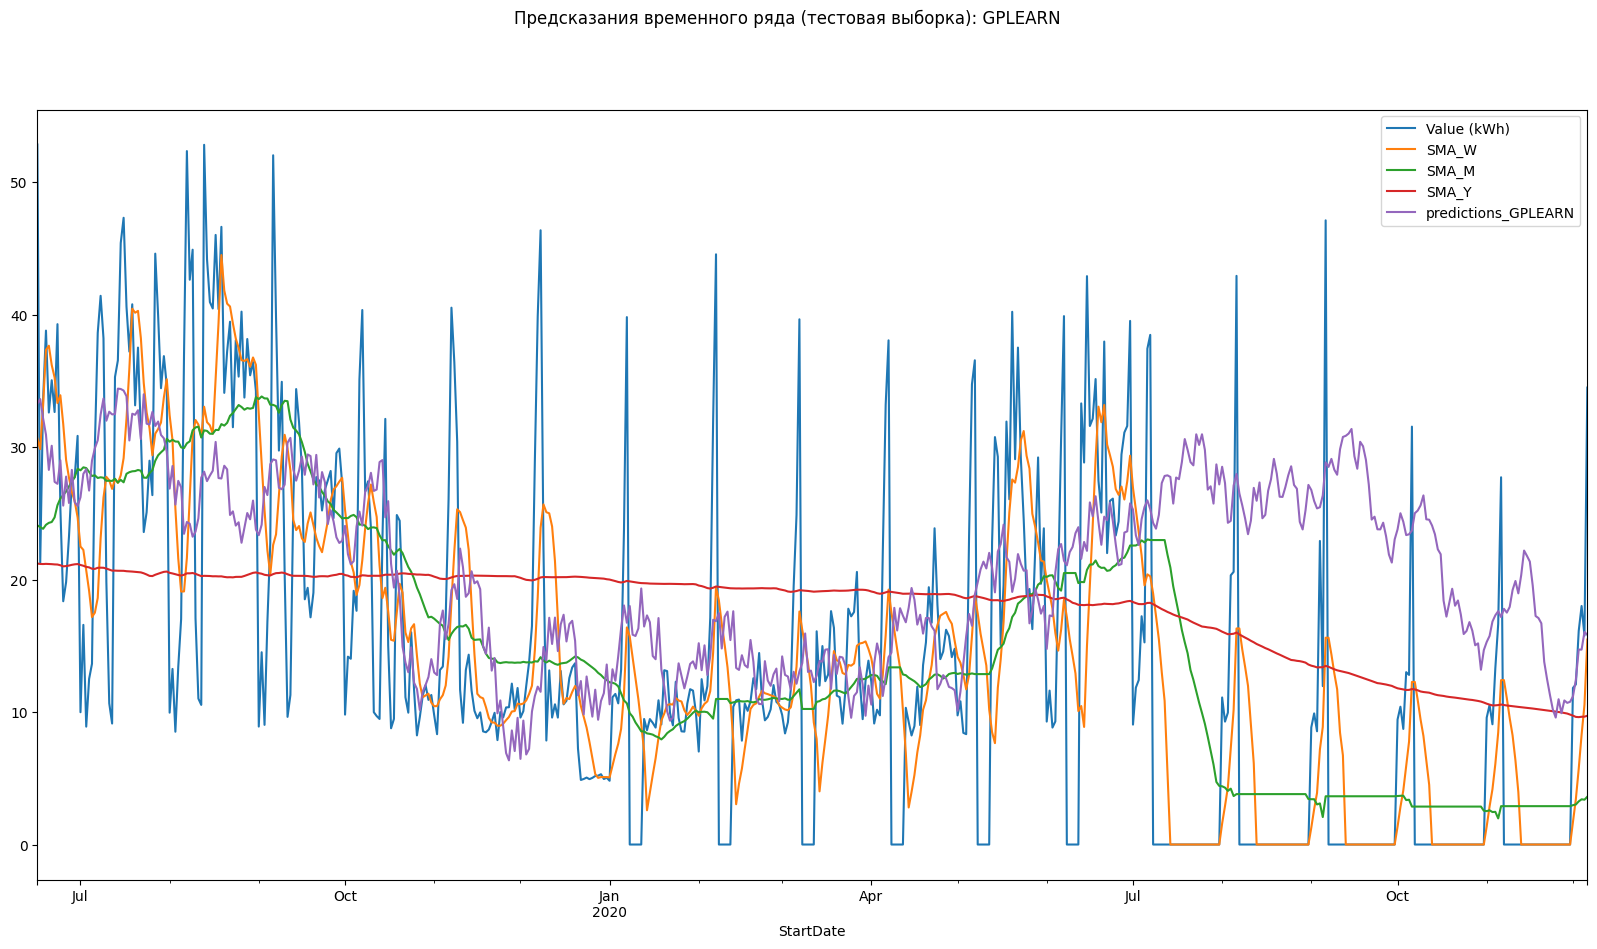

In [145]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда (тестовая выборка): GPLEARN')
ts2.drop(["predictions_ARIMA", "predictions_HWES"], axis=1)[train_size:].plot(ax=ax, legend=True)
pyplot.show()
